<a href="https://colab.research.google.com/github/Ivyson/Neural-Network-XOR/blob/main/ConvolutionalNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Layered Perceptrons
This architecture discussed from the previous sessions, Having input layer accepting one dimensioned array has actually paved a route for the CNN that we will be covering here in this session. MLPs are very simplistic, accepting data presented in a table format and learning from them, making decisions based on such data. Now, the real life data is much dimensioned than just a 1 dimensioned data, flattening this data straight away destroys the important data carried by this real life data. an image could be used as an example to illustrate this.

One of the models we built before was using the MNIST-Number dataset which we used to predict a sketched number on an image. This model gave around 87% accuracy and it was behaving remarkably outstanding, but now, why would we want to develop a new architecture if the basic MLP can understand pictures too?. Now, the catch lies here, The MNIST dataset that was used was only kept at $ 28 \times 28$ Pixel count, this meant we had to flatten the image to create 784 input nuerons, even though this is not a huge number to compute, as images become more advanced, we start getting the scales of $1020 \times 720$ which will mean that we have to create an MLP with Input Nuerons of $\approx 74$ Thousand. Pictures are now 4K too, which even increases the computational power required to deal with these pictures as you use the MLP. This is even much less of a concern ever since computational power can be bought, but accuracy is a major concern now.

The MNIST dataset is made of only black and white colors, The white coloured pixels representing the drawing of a number, which is referred to a grey-scaling. Now pictures are not just black and white but consisting of complex colors which are Red, Green & Blue, This means that each pixel has an array of 3 values, Red, Green and Blue respectively. If the intention is to use an mlp on such images, the model prediction will be dramatically questionable, this is due the idea that the nearby pixels are carrying important information about each other, so directly flattening these pixels will cause the nearby pictures to be far from each other, hence the pattern will be lost, leading to incorrect predictions.

This is not only observed on images but signals. The end goal for this project is to design a model that can understand the pattern in the EEG signals, But often than not, the signals also follow a specific pattern, Signals are continious and have huge value set at each point. So, for example, if you had a signal that looked like a wave like a heartbeat or sound wave, instead of treating it as something that moves over time, the MLP just sees a row of numbers without any idea of the order or shape of the signal. That’s already a problem, because signals are meaningful because of how they change over time. If you take away the structure of the signal, the model loses the chance to understand patterns like rising and falling edges, repetition, or trends that appear in sequence.  Another big issue is that MLPs connect every input to every neuron in the next layer. So if you give it a signal that has, say, 10,000 numbers, which is not unusual for audio and other high-resolution signals, and your first hidden layer has just 100 neurons, you now have 1 million weights. That’s a lot of numbers for the network to learn, and it means the model can easily memorize the training data instead of learning general patterns. It also means training becomes slower and more demanding on the computer. All this effort — and yet, the model still isn’t really understanding what’s happening across time in the signal.

Now This pushes us to finding more robust methods of dealing with such datasets and find more efficient and reliable ways in which we can compute a model that can predict such datasets. Which is what we will be covering here, **CNNs**

# Convulational Nueral Networks (CNNs)
The name of the Model comes from the operation that happens under the hood of this architecture. Instead of Connecting every input to the next nueron as seen in the MLP, CNNs make use of Convolutiona Filters to look for local regions of the dataset. These filters are moved along the dataset, detecting the patterns within the input data, such as the edges(spikes), textures(for images) & specific shapes. The `Filters` are also known as `Kernel` Windows, becuase they are relatively smaller matrix system than the input data, which is imposed on the input data and then perfoming some mathematical operation within that specific dataset. The mathemathical operation is *Element-wise multiplication* then Adding the product of the output data

<b>![Need to attach the example of the animation here]</b>

Oftenly this part is done a couple of times by a couple of filters, each filter extracting specific information about the signal. This is then followed by the **Activation Function**. This function performs a specific manipulation to the input data, Example of it includes:  *Rectified Linear Unit* which replaces all the non positive values by 0 and then leaving the positive values as is. This part here is important for allowing the nueral network to learn faster, Remember that when we have only values from 0 going up, the dataset is much more easier to interpret rather than when it lies both ways of the cartesian plane. Even though this function is not always useful, we can also use *Tanh(x)* function which squashes every data to the range of [-1, 1], Another useful function could be a Leaky Relu or Parameterised relu, which squashes the negative values to be closer to zero and then keeping the positive values as they are.. Which Activation Function is better entirely depends on the application of your model. Also, to keep in mind, the data that is squashed or manipulated is **not** the input data but the convolved data, For an example, If we apply a Relu on the dataset that was convolved using a filter that extracts sharp edges from a picture, the relu will replace the dataset that was detected to have less(or negative) sharp edges with zeros, Allowing us to sharply detect edges on the image. This process is then followed by `Pooling`

`Pooling`, which down samples or super - samples the data from the Actication Function, for the purpose of this paper, we will be focusing on Down sampling because we need to feed the Network less data at the end of the day while retrieving enough information about the input data as much as possible.

**Pooling** is a matrix system that hovers around the output matrix of the Convolution and the input data, the Pooling process extracts key feautures in that output by retaining the important spatial information while shirinking the data. The Pooling process that will be used here will be *Max Pooling* Which will be a $2\times 2$ Matrix that will hover around all the data from the convolution, finding the maximum in that small window of $2\times 2$ and then ignoring all the other data. The Process of pooling is demonstrated below as follows

<b>Need to Attach the Pooling Demo Here</b>

From the pooling demonstration above, we can see that even though the data i shrank into a smaller scale, the spatial information of the image is still retained but just represented as a smaller scale. Now, Finally after performing Convolution, Activation & Pooling a couple of times, we now have a smaller matrix which has just important dataset that we need, these are then flattened and then sent into an MLP architecture. MLP will be responsible for classification problems like identifying if the dataset represents a dog or a cat etc.. or any other manipulation from the data (Binary Classification, Regression etc..)

# How do we select the right Filter
Remember that the filter exctracts important features from the input data, More Features needed implies more Filters required. Because we need to extract more features from the input dataset , we should use something around 8 or 16 filters if we are dealing with smaller dataset, and 32 or 64 for larger datasets. and then as you move away from the Input data, we can then use lesser filters, However the number of filters used is experimental to each problem. How many Filters you need depends on the complexity and the sensitivity of your problem statement, but generally, 3 filters would be able to extract a few feautures in your dataset, but 10 would be exponentially better but computationally would take longer to train.

The data within the filters is initially randomly generated, Therefore, they are not really extracting anything tangible from the input data, but the accuracy depends on the feed forward and the back propagation of the network.
## How the process occurs
During each iteration, the network takes the input data like a signal or image and applies these random filters to extract features. The filter performs a convolution operation over the input, creating a feature map. The feature map is then passed through activation functions like ReLU, and eventually through pooling layers. After the forward pass, the network makes a prediction (e.g., classifying the signal or image). The model then compares this prediction to the true label (ground truth) using a loss function (e.g., Mean Squared Error or Cross-Entropy Loss).

After calculating the loss, the network uses backpropagation to update the filters. The network calculates how much each filter contributed to the error Then, it adjusts the filter values using a technique called gradient descent(Described On the first MLP Notes) to minimize the error. This means the filters change to better capture important patterns in the data. The learning rate taht was parsed in initially controls how much the filter values change during each update.
- Initially during the early training, The filters will still look random, and the feature maps produced might not make much sense. However, as the model learns from the data, it starts adjusting the filters to highlight useful feautures like edge, textures etc.. (These have been mentioned a couple of times now...) Now as the Training continues, the filters specialise in different aspects. The fact that these are randomly generated is what gives us hope that these filters **Will** focus on different aspects of the signal to give us a correct output. If the filters were all the same then we would be having the same filters focusing on the same feature, outputting the same output, causing the model to not learn anything useful at all.








# References
[Brain Tumor Detection Dataset](https://www.kaggle.com/code/abutahimhabiby/brain-tumor-detection-cnn-clahe-92-16-val)

[Convolutional Filters Animation](https://deeplizard.com/resource/pavq7noze2)

[Convolution Max Pooling Example](https://deeplizard.com/resource/pavq7noze3)

[MIT Lecture](https://youtu.be/oGpzWAlP5p0?si=GWiR08AY9alW7Ie7)

[3B1B ](https://youtu.be/KuXjwB4LzSA?si=BDwR451OXyqXuSVm)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Loading Model ---
Model loaded successfully from brain_tumor_cnn.pkl
Model loaded successfully.
Do you want to 'train' a new model or 'test' an existing one? (train/test): test
Enter the filename of the pre-trained model to load [brain_tumor_cnn.pkl]: 

--- Starting Testing & Visualization Pipeline ---
Attempting to load model: brain_tumor_cnn.pkl
Using Test Data from: /content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/Test
Expected Target Size: (96, 96)
Model loaded successfully from brain_tumor_cnn.pkl
Model loaded successfully.

--- Loading Test Data ---
Detected class subfolders: No, Yes
Loaded 31 images.
Loaded 31 test images.
Class map: {'No': 0, 'Yes': 1}
Labels formatted for binary visualization.

--- Visualizing Predictions ---

Visualizing 8 sample predictions...


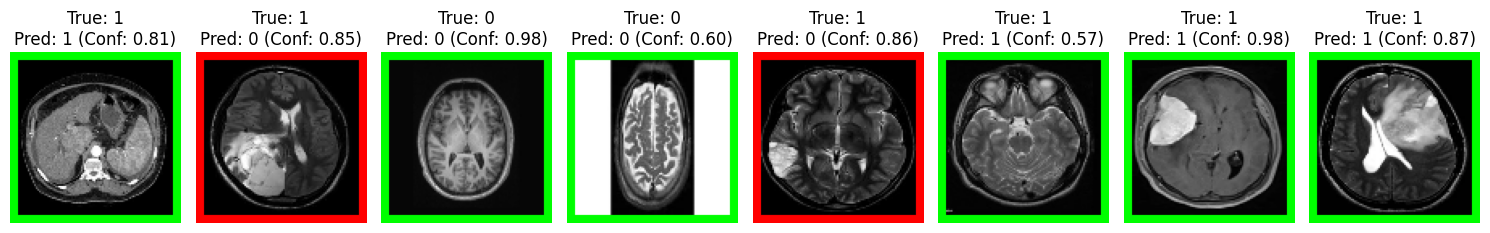


--- Testing/Visualization Pipeline Finished ---

--- Script Finished ---


In [19]:
import numpy as np
import scipy.signal # Used by Conv2D
import pickle
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import Tuple, Optional, List, Dict, Any, Callable, Union # Keep type hints
from google.colab import drive
drive.mount('/content/drive')
!pip install opencv-python


# cglobal constants
ADAM_BETA1 = 0.9
ADAM_BETA2 = 0.999
ADAM_EPSILON = 1e-8
LEAKY_RELU_ALPHA = 0.01

# Activation FUNCTIONS
def _sigmoid(x: np.ndarray) -> np.ndarray:
    """Returns a much stable Sigmoid function."""
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def _sigmoid_derivative(output: np.ndarray) -> np.ndarray:
    """Derivative of sigmoid (using its output)."""
    return output * (1 - output)

def _relu(x: np.ndarray) -> np.ndarray:
    """Rectified Linear Unit activation."""
    return np.maximum(0, x)

def _relu_derivative(output: np.ndarray) -> np.ndarray:
    """Derivative of ReLU."""
    return np.where(output > 0, 1, 0) # This here is because the derivative at 0 is undefined

def _leaky_relu(x: np.ndarray) -> np.ndarray:
    """Leaky Rectified Linear Unit activation."""
    return np.where(x > 0, x, x * LEAKY_RELU_ALPHA)

def _leaky_relu_derivative(output: np.ndarray) -> np.ndarray:
    """Derivative of Leaky ReLU."""
    return np.where(output > 0, 1, LEAKY_RELU_ALPHA)

def _softmax(x: np.ndarray) -> np.ndarray:
    """Softmax activation function."""
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / (np.sum(exp_x, axis=-1, keepdims=True) + 1e-9) # Add epsilon for stability

def _softmax_derivative_cross_entropy(output: np.ndarray, y_true: np.ndarray) -> np.ndarray:
    """
    Computes the gradient of the cross-entropy loss with respect to the
    inputs of the softmax function (often denoted dL/dz).
    This combined gradient is simply (output - y_true).
    Note: This function isn't the derivative of softmax itself, but
          the combined gradient needed for backprop when using softmax + cross-entropy.
    The `output_gradient` passed to the Activation layer's backward pass in this case
    should be y_true. The loss gradient calculation should return y_pred - y_true.
    So, the backward pass of Softmax Activation simplifies.
    """
    pass # Logic Implemented on the CNN Already

def _linear(x: np.ndarray) -> np.ndarray:
    """Linear activation (identity)."""
    return x

def _linear_derivative(output: np.ndarray) -> np.ndarray:
    """Derivative of linear activation."""
    return np.ones_like(output)

ACTIVATION_FUNCTIONS: Dict[str, Callable[[np.ndarray], np.ndarray]] = {
    'sigmoid': _sigmoid,
    'relu': _relu,
    'leaky_relu': _leaky_relu,
    'softmax': _softmax,
    'linear': _linear,
}

ACTIVATION_DERIVATIVES: Dict[str, Callable[[np.ndarray], np.ndarray]] = {
    'sigmoid': _sigmoid_derivative,
    'relu': _relu_derivative,
    'leaky_relu': _leaky_relu_derivative,
    'softmax': lambda output: output * (1-output),
    'linear': _linear_derivative,
}


# tEH Loss Functions

def mean_squared_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Calculates Mean Squared Error loss."""
    return np.mean(np.sum((y_true - y_pred) ** 2, axis=1))

def mean_squared_error_gradient(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """Calculates the gradient of Mean Squared Error loss."""
    return 2 * (y_pred - y_true) / y_true.shape[0]

def categorical_cross_entropy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Calculates Categorical Cross-Entropy loss."""
    # Clip predictions to avoid log(0)
    epsillon = 1e-9
    y_pred_clipped = np.clip(y_pred, epsillon, 1 - epsillon)
    return -np.mean(np.sum(y_true * np.log(y_pred_clipped), axis=1))

def categorical_cross_entropy_gradient(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """
    Calculates the gradient of CCE loss w.r.t y_pred.
    When combined with Softmax, the gradient w.r.t the Softmax *input* simplifies.
    """
    return (y_pred - y_true) / y_true.shape[0]


LOSS_FUNCTIONS: Dict[str, Callable] = {
    'mse': mean_squared_error,
    'categorical_crossentropy': categorical_cross_entropy,
}

LOSS_GRADIENTS: Dict[str, Callable] = {
    'mse': mean_squared_error_gradient,
    'categorical_crossentropy': categorical_cross_entropy_gradient,
}

#Base Layer Architecture Class..
class Layer:
    """Base class for all network layers."""
    def __init__(self):
        self.input: Optional[np.ndarray] = None
        self.output: Optional[np.ndarray] = None
        self._has_weights = False # Flag to indicate if layer has trainable weights

    def forward(self, input_data: np.ndarray) -> np.ndarray:
        """Perform the forward pass."""
        raise NotImplementedError

    def backward(self, output_gradient: np.ndarray, learning_rate: float, **kwargs) -> np.ndarray:
        """
        Perform the backward pass.
        kwargs might include Adam parameters like t, beta1, beta2, epsilon.
        """
        raise NotImplementedError

    def has_weights(self) -> bool:
        """Check if the layer has trainable weights."""
        return self._has_weights


class Activation(Layer):
    """Applies an activation function element-wise."""
    def __init__(self, activation_name: str):
        """
        Initialize activation layer.

        :param activation_name: Name of the activation function
                                ('sigmoid', 'relu', 'leaky_relu', 'softmax', 'linear').
        """
        super().__init__()
        if activation_name not in ACTIVATION_FUNCTIONS:
            raise ValueError(f"Unknown activation function: '{activation_name}'")
        self.activation_name = activation_name
        self.activation_func = ACTIVATION_FUNCTIONS[activation_name]
        self.activation_derivative = ACTIVATION_DERIVATIVES.get(activation_name)
        if self.activation_derivative is None and self.activation_name != 'softmax':
             raise ValueError(f"Derivative for '{activation_name}' not found.")


    def forward(self, input_data: np.ndarray) -> np.ndarray:
        """Perform the forward pass applying the activation function."""
        self.input = input_data
        self.output = self.activation_func(input_data)
        return self.output

    def backward(self, output_gradient: np.ndarray, learning_rate: Optional[float] = None, **kwargs) -> np.ndarray:
        """
        Perform the backward pass through the activation function.

        :param output_gradient: Gradient from the next layer.
        :param learning_rate: Not used for activation layer.
        :param kwargs: May include y_true for Softmax+CCE simplification.
        :return: Gradient with respect to the input of this layer.
        """
        if self.activation_name == 'softmax':
            return output_gradient
        elif self.activation_derivative:
             # Apply chain rule: dL/dx = dL/dy * dy/dx
             # where y = activation_func(x)
             # dy/dx is the activation_derivative evaluated at the output y (or input x sometimes)
            return output_gradient * self.activation_derivative(self.output)
        else:
            raise RuntimeError(f"Cannot perform backward pass for {self.activation_name} without derivative.")

class Conv2D(Layer):
    """2D Convolutional Layer."""
    def __init__(self, input_shape: Tuple[int, int, int], kernel_size: Tuple[int, int], depth: int):
        """
        Initialize convolutional layer.

        :param input_shape: Shape of the input volume (height, width, channels).
        :param kernel_size: Size of the convolution kernel (height, width).
        :param depth: Number of kernels/filters (output depth).
        """
        super().__init__()
        self._has_weights = True
        self.input_height, self.input_width, self.input_channels = input_shape
        self.kernel_height, self.kernel_width = kernel_size
        self.depth = depth # Number of output filters

        if not (isinstance(kernel_size, tuple) and len(kernel_size) == 2):
             raise ValueError("kernel_size must be a tuple of two integers (height, width).")
        if not (isinstance(input_shape, tuple) and len(input_shape) == 3):
             raise ValueError("input_shape must be a tuple of three integers (height, width, channels).")

        # Xavier initialization
        self.kernels_shape = (self.kernel_height, self.kernel_width, self.input_channels, self.depth)
        limit = np.sqrt(6 / (np.prod(kernel_size) * self.input_channels + np.prod(kernel_size) * self.depth))
        self.kernels = np.random.uniform(-limit, limit, self.kernels_shape)
        self.biases = np.zeros(self.depth) # One bias per output filter

        # Adam optimizerz
        self.m_kernels = np.zeros_like(self.kernels)
        self.v_kernels = np.zeros_like(self.kernels)
        self.m_biases = np.zeros_like(self.biases)
        self.v_biases = np.zeros_like(self.biases)

        self.output_height = self.input_height - self.kernel_height + 1
        self.output_width = self.input_width - self.kernel_width + 1
        if self.output_height <= 0 or self.output_width <= 0:
            raise ValueError(f"Kernel size {kernel_size} is too large for input shape {input_shape[:2]}.")
        self.output_shape = (self.output_height, self.output_width, self.depth)

    def forward(self, input_data: np.ndarray) -> np.ndarray:
        """
        Perform the forward pass using convolution.

        Note: This implementation uses scipy.signal.convolve2d which is
              computationally expensive for large inputs/kernels compared to
              optimized libraries (like TensorFlow, PyTorch) using im2col or FFT.

        :param input_data: Input data of shape (batch_size, height, width, channels).
        :return: Output feature map of shape (batch_size, new_height, new_width, depth).
        """
        self.input = input_data
        batch_size = input_data.shape[0]

        # Initialize output array
        self.output = np.zeros((batch_size, *self.output_shape))

        for i in range(batch_size):
            for d in range(self.depth):
                output_feature_map = np.zeros((self.output_height, self.output_width))
                for c in range(self.input_channels):
                    # Kernel shape: (kH, kW, InChannels, OutDepth)
                    kernel_slice = self.kernels[:, :, c, d]
                    input_slice = self.input[i, :, :, c]
                    output_feature_map += scipy.signal.convolve2d(
                        input_slice, kernel_slice, mode='valid'
                    )
                # Add bias
                self.output[i, :, :, d] = output_feature_map + self.biases[d]

        return self.output

    def _adam_update(self, param: np.ndarray, grad: np.ndarray, m: np.ndarray, v: np.ndarray,
                     learning_rate: float, t: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Helper function to perform Adam update."""
        m = ADAM_BETA1 * m + (1 - ADAM_BETA1) * grad
        v = ADAM_BETA2 * v + (1 - ADAM_BETA2) * (grad ** 2)

        m_hat = m / (1 - ADAM_BETA1 ** t)
        v_hat = v / (1 - ADAM_BETA2 ** t)

        # Update
        param -= learning_rate * m_hat / (np.sqrt(v_hat) + ADAM_EPSILON)
        return param, m, v

    def backward(self, output_gradient: np.ndarray, learning_rate: float, **kwargs) -> np.ndarray:
        """
        Perform the backward pass to compute gradients and update weights using Adam.

        Note: This implementation uses scipy.signal correlate2d/convolve2d,
              which can be slow.

        :param output_gradient: Gradient from the next layer, shape (batch_size, out_h, out_w, depth).
        :param learning_rate: Learning rate for the optimizer.
        :param kwargs: Expected to contain 't' (Adam timestep).
        :return: Gradient with respect to the input of this layer.
        """
        if 't' not in kwargs:
            raise ValueError("Adam timestep 't' is required for backward pass.")
        t = kwargs['t']

        batch_size = output_gradient.shape[0]
        kernels_gradient = np.zeros_like(self.kernels)
        biases_gradient = np.zeros_like(self.biases)
        input_gradient = np.zeros_like(self.input)

        for i in range(batch_size):
            for d in range(self.depth):
                biases_gradient[d] += np.sum(output_gradient[i, :, :, d])

                for c in range(self.input_channels):
                    input_slice = self.input[i, :, :, c]
                    output_grad_slice = output_gradient[i, :, :, d]
                    kernels_gradient[:, :, c, d] += scipy.signal.correlate2d(
                        input_slice, output_grad_slice, mode='valid'
                    )

                    kernel_slice = self.kernels[:, :, c, d]
                    rotated_kernel = np.rot90(kernel_slice, 2) # Rotate 180 degrees
                    input_gradient[i, :, :, c] += scipy.signal.convolve2d(
                        output_grad_slice, rotated_kernel, mode='full'
                    )

        # Update kernels and biases using Adam
        self.kernels, self.m_kernels, self.v_kernels = self._adam_update(
            self.kernels, kernels_gradient, self.m_kernels, self.v_kernels, learning_rate, t
        )
        self.biases, self.m_biases, self.v_biases = self._adam_update(
            self.biases, biases_gradient, self.m_biases, self.v_biases, learning_rate, t
        )

        return input_gradient


class MaxPool2D(Layer):
    """2D Max Pooling Layer."""
    def __init__(self, pool_size: Tuple[int, int] = (2, 2), stride: Optional[Tuple[int, int]] = None):
        """
        Initialize max pooling layer.

        :param pool_size: Size of the pooling window (height, width).
        :param stride: Step size for pooling. If None, defaults to pool_size.
        """
        super().__init__()
        self.pool_height, self.pool_width = pool_size
        self.stride_h, self.stride_w = stride if stride is not None else pool_size
        self.max_indices: Optional[np.ndarray] = None

    def forward(self, input_data: np.ndarray) -> np.ndarray:
        """
        Perform the forward pass using max pooling.

        :param input_data: Input data of shape (batch_size, height, width, channels).
        :return: Output after max pooling.
        """
        self.input = input_data
        batch_size, h_in, w_in, channels = input_data.shape

        h_out = (h_in - self.pool_height) // self.stride_h + 1
        w_out = (w_in - self.pool_width) // self.stride_w + 1
        if h_out <= 0 or w_out <= 0:
            raise ValueError(f"Pool size {self.pool_height, self.pool_width} with stride {self.stride_h, self.stride_w} "
                             f"is too large for input shape {h_in, w_in}.")

        output = np.zeros((batch_size, h_out, w_out, channels))

        self.max_indices = np.zeros((batch_size, h_out, w_out, channels, 2), dtype=int)

        for b in range(batch_size):
            for c in range(channels):
                for i in range(h_out):
                    for j in range(w_out):
                        h_start = i * self.stride_h
                        h_end = h_start + self.pool_height
                        w_start = j * self.stride_w
                        w_end = w_start + self.pool_width

                        pool_region = input_data[b, h_start:h_end, w_start:w_end, c]

                        max_val = np.max(pool_region)
                        max_pos_relative = np.unravel_index(np.argmax(pool_region), pool_region.shape)

                        output[b, i, j, c] = max_val
                        self.max_indices[b, i, j, c] = max_pos_relative

        self.output = output
        return output

    def backward(self, output_gradient: np.ndarray, learning_rate: Optional[float] = None, **kwargs) -> np.ndarray:
        """
        Perform the backward pass for max pooling.

        Distributes the gradient only to the locations where the max value was originally found.

        :param output_gradient: Gradient from the next layer.
        :param learning_rate: Not used for pooling layer.
        :return: Gradient with respect to the input of this layer.
        """
        if self.input is None or self.max_indices is None:
            raise RuntimeError("Forward pass must be called before backward pass.")

        batch_size, h_out, w_out, channels = output_gradient.shape
        input_gradient = np.zeros_like(self.input)

        for b in range(batch_size):
            for c in range(channels):
                for i in range(h_out):
                    for j in range(w_out):
                      # Window Cordinates
                        h_start = i * self.stride_h
                        w_start = j * self.stride_w

                        h_max_rel, w_max_rel = self.max_indices[b, i, j, c]

                        h_abs = h_start + h_max_rel
                        w_abs = w_start + w_max_rel

                        input_gradient[b, h_abs, w_abs, c] += output_gradient[b, i, j, c]

        return input_gradient


#
class Flatten(Layer):
    """Flattens the input volume into a vector."""
    def __init__(self):
        super().__init__()
        self.original_shape: Optional[Tuple[int, ...]] = None

    def forward(self, input_data: np.ndarray) -> np.ndarray:
        """
        Perform the forward pass, flattening the input.

        :param input_data: Input data of shape (batch_size, height, width, channels) or similar.
        :return: Flattened data of shape (batch_size, height * width * channels).
        """
        self.input = input_data
        self.original_shape = input_data.shape
        batch_size = input_data.shape[0]

        flattened_dim = np.prod(input_data.shape[1:])

        self.output = input_data.reshape(batch_size, flattened_dim)
        return self.output

    def backward(self, output_gradient: np.ndarray, learning_rate: Optional[float] = None, **kwargs) -> np.ndarray:
        """
        Perform the backward pass, reshaping the gradient back to the original input shape.

        :param output_gradient: Gradient from the next layer (flattened).
        :param learning_rate: Not used for flatten layer.
        :return: Gradient with respect to the input (reshaped).
        """
        if self.original_shape is None:
             raise RuntimeError("Forward pass must be called before backward pass.")

        return output_gradient.reshape(self.original_shape)


class Dense(Layer):
    """Dense (fully connected) layer."""
    def __init__(self, input_size: int, output_size: int):
        """
        Initialize dense layer. Activation should be applied by a subsequent Activation layer.

        :param input_size: Number of input features (neurons in the previous layer).
        :param output_size: Number of output features (neurons in this layer).
        """
        super().__init__()
        self._has_weights = True
        self.input_size = input_size
        self.output_size = output_size

        # Xavier
        limit = np.sqrt(6 / (input_size + output_size))
        self.weights = np.random.uniform(-limit, limit, (input_size, output_size))
        self.biases = np.zeros(output_size) # One bias per output neuron

        # Adam
        self.m_weights = np.zeros_like(self.weights)
        self.v_weights = np.zeros_like(self.weights)
        self.m_biases = np.zeros_like(self.biases)
        self.v_biases = np.zeros_like(self.biases)


    def forward(self, input_data: np.ndarray) -> np.ndarray:
        """
        Perform the forward pass (linear transformation Wx + b).

        :param input_data: Input data of shape (batch_size, input_size).
        :return: Output of shape (batch_size, output_size).
        """
        self.input = input_data
        self.output = np.dot(input_data, self.weights) + self.biases
        return self.output

    def _adam_update(self, param: np.ndarray, grad: np.ndarray, m: np.ndarray, v: np.ndarray,
                     learning_rate: float, t: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Helper function to perform Adam update."""
        m = ADAM_BETA1 * m + (1 - ADAM_BETA1) * grad
        v = ADAM_BETA2 * v + (1 - ADAM_BETA2) * (grad ** 2)

        m_hat = m / (1 - ADAM_BETA1 ** t)
        v_hat = v / (1 - ADAM_BETA2 ** t)

        # Update parameter
        param -= learning_rate * m_hat / (np.sqrt(v_hat) + ADAM_EPSILON)
        return param, m, v

    def backward(self, output_gradient: np.ndarray, learning_rate: float, **kwargs) -> np.ndarray:
        """
        Perform the backward pass for the dense layer using Adam optimizer.

        Note: This gradient `output_gradient` is dL/dz where z is the output of this Dense layer
              (BEFORE any activation is applied). It comes from the subsequent Activation layer's
              backward pass.

        :param output_gradient: Gradient from the next layer (typically an Activation layer).
                                Shape: (batch_size, output_size).
        :param learning_rate: Learning rate for the optimizer.
        :param kwargs: Expected to contain 't' (Adam timestep).
        :return: Gradient with respect to the input of this layer (dL/dx).
                 Shape: (batch_size, input_size).
        """
        if 't' not in kwargs:
            raise ValueError("Adam timestep 't' is required for backward pass.")
        if self.input is None:
             raise RuntimeError("Forward pass must be called before backward pass.")
        t = kwargs['t']

        weights_gradient = np.dot(self.input.T, output_gradient)

        biases_gradient = np.sum(output_gradient, axis=0)
        input_gradient = np.dot(output_gradient, self.weights.T)
        self.weights, self.m_weights, self.v_weights = self._adam_update(
            self.weights, weights_gradient, self.m_weights, self.v_weights, learning_rate, t
        )
        self.biases, self.m_biases, self.v_biases = self._adam_update(
            self.biases, biases_gradient, self.m_biases, self.v_biases, learning_rate, t
        )

        return input_gradient


class CNN:
    """Convolutional Neural Network model."""
    def __init__(self, learning_rate: float = 0.001, loss: str = 'mse'):
        """
        Initialize CNN model.

        :param learning_rate: Learning rate for the Adam optimizer.
        :param loss: Name of the loss function ('mse' or 'categorical_crossentropy').
        """
        if loss not in LOSS_FUNCTIONS:
            raise ValueError(f"Unsupported loss function: '{loss}'. Supported: {list(LOSS_FUNCTIONS.keys())}")

        self.layers: List[Layer] = []
        self.learning_rate = learning_rate
        self.loss_func = LOSS_FUNCTIONS[loss]
        self.loss_gradient_func = LOSS_GRADIENTS[loss]
        self.loss_name = loss
        self.t = 0

    def add(self, layer: Layer):
        """Add a layer to the model."""
        if not isinstance(layer, Layer):
            raise TypeError("Can only add objects derived from the Layer class.")
        self.layers.append(layer)

    def predict(self, input_data: np.ndarray) -> np.ndarray:
        """
        Make predictions with the model.

        :param input_data: Input data, shape depends on the first layer.
                           (batch_size, height, width, channels) for Conv2D.
                           (batch_size, features) for Dense.
        :return: Model predictions, shape depends on the last layer.
        """

        if input_data.ndim == 1:
             input_data = np.expand_dims(input_data, axis=0)
        elif input_data.ndim == 3 and isinstance(self.layers[0], Conv2D): # Single image
             input_data = np.expand_dims(input_data, axis=0)

        output = input_data
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def train(self, X_train: np.ndarray, y_train: np.ndarray, epochs: int, batch_size: int = 32, verbose: bool = True):
        """
        Train the model using batches.

        :param X_train: Training data.
        :param y_train: Training labels (must match the output shape and loss function).
                        For MSE/Sigmoid output: (n_samples, 1)
                        For CCE/Softmax output: (n_samples, n_classes) (one-hot encoded).
        :param epochs: Number of training epochs.
        :param batch_size: Number of samples per gradient update.
        :param verbose: Whether to print progress.
        """
        n_samples = X_train.shape[0]

        if n_samples == 0:
             print("Warning: Training data is empty.")
             return

        for epoch in range(epochs):
            epoch_loss = 0
            # Shuffle data at the beginning of each epoch
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i : min(i + batch_size, n_samples)]
                y_batch = y_shuffled[i : min(i + batch_size, n_samples)]

                if len(X_batch) == 0: continue

                output = self.predict(X_batch)

                epoch_loss += self.loss_func(y_batch, output) * len(X_batch)

                self.t += 1
                grad = self.loss_gradient_func(y_batch, output)
                for layer in reversed(self.layers):
                    adam_params = {}
                    if layer.has_weights():
                        adam_params = {'t': self.t}

                    grad = layer.backward(grad, self.learning_rate, **adam_params)
            average_epoch_loss = epoch_loss / n_samples

            if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
                print(f"Epoch {epoch+1}/{epochs}, Loss: {average_epoch_loss:.6f}")

    def save_model(self, filename: str):
        """Save the trained model to a file using pickle."""

        for layer in self.layers:
            layer.input = None
            layer.output = None
            if isinstance(layer, MaxPool2D):
                 layer.max_indices = None

        try:
            with open(filename, 'wb') as f:
                pickle.dump(self, f)
            print(f"Model saved successfully to {filename}")
        except Exception as e:
            print(f"Error saving model to {filename}: {e}")

    @classmethod
    def load_model(cls, filename: str) -> 'CNN':
        """Load a model from a pickle file."""
        try:
            with open(filename, 'rb') as f:
                model = pickle.load(f)
            if not isinstance(model, cls):
                 raise TypeError(f"Loaded object is not of type {cls.__name__}")
            print(f"Model loaded successfully from {filename}")

            return model
        except FileNotFoundError:
            print(f"Error: Model file not found at {filename}")
            raise
        except Exception as e:
            print(f"Error loading model from {filename}: {e}")
            raise


def load_and_preprocess_images(image_folder: str, target_size: Tuple[int, int]=(128, 128)) -> Tuple[np.ndarray,np.ndarray,Dict[str,int]]:
    images=[]; labels=[]; class_to_index: Dict[str,int]={}; index_counter=0
    if not os.path.isdir(image_folder): print(f"Error: Folder not found: {image_folder}"); return np.array([]),np.array([]),{}
    contents=os.listdir(image_folder); subdirs=[i for i in contents if os.path.isdir(os.path.join(image_folder,i))]
    if subdirs:
        print(f"Detected class subfolders: {', '.join(sorted(subdirs))}")
        for class_name in sorted(subdirs):
            if class_name not in class_to_index: class_to_index[class_name]=index_counter; index_counter+=1
            class_idx=class_to_index[class_name]; class_folder=os.path.join(image_folder,class_name)
            for filename in os.listdir(class_folder):
                if filename.lower().endswith(('.jpeg','.jpg','.png','.bmp','.gif')):
                    img=cv2.imread(os.path.join(class_folder, filename))
                    if img is None: print(f" Warning: Could not load {filename}"); continue
                    if len(img.shape)==2: img=cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
                    else: img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                    img_resized=cv2.resize(img,target_size)
                    img_normalized=img_resized.astype(np.float32)/255.0
                    images.append(img_normalized); labels.append(class_idx)
    else:
        print(f"No subfolders found. Assuming single class 'class_0'.")
        class_name='class_0'; class_to_index[class_name]=0; class_idx=0
        for filename in contents:
            if filename.lower().endswith(('.jpeg','.jpg','.png','.bmp','.gif')):
                 img=cv2.imread(os.path.join(image_folder,filename))
                 if img is None: print(f" Warning: Could not load {filename}"); continue
                 if len(img.shape)==2: img=cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
                 else: img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                 img_resized=cv2.resize(img,target_size)
                 img_normalized=img_resized.astype(np.float32)/255.0
                 images.append(img_normalized); labels.append(class_idx)
    if not images: print("Warning: No valid images loaded."); return np.array([]),np.array([]),{}
    print(f"Loaded {len(images)} images.")
    return np.array(images), np.array(labels), class_to_index

def visualize_predictions(
    model: CNN,
    images: np.ndarray,
    true_labels: np.ndarray,
    class_map: Dict[str, int],
    num_samples: int = 5,
    figsize: Tuple[int, int] = (15, 7)
):
    """
    Visualize model predictions alongside true labels for a few sample images.
    Displays predicted label as 0 or 1 for binary classification.
    Attempts to display float images directly.

    :param model: The trained CNN model instance.
    :param images: Array of images to predict on (preprocessed, float32, range [0,1]).
    :param true_labels: Corresponding true labels (formatted, e.g., (N, 1) for binary).
    :param class_map: Dictionary mapping class names (str) to integer indices (int).
    :param num_samples: Number of random samples to display.
    :param figsize: Figure size for the plot.
    """
    num_total_images = images.shape[0]
    if num_total_images == 0:
        print("No images provided for visualization.")
        return

    num_samples = min(num_samples, num_total_images)
    if num_samples <= 0:
         print("num_samples must be positive.")
         return

    indices = np.random.choice(num_total_images, num_samples, replace=False)

    index_to_class = {v: k for k, v in class_map.items()}

    model_output_size = None
    for layer in reversed(model.layers):
        if hasattr(layer, 'output_size') and layer.output_size is not None:
            model_output_size = layer.output_size
            break
    if model_output_size is None:
        try: model_output_size=model.predict(np.expand_dims(images[0],axis=0)).shape[1]
        except Exception as e: print(f"Error inferring output size: {e}"); return


    fig, axes = plt.subplots(1, num_samples, figsize=figsize)
    if num_samples == 1: axes = [axes]

    print(f"\nVisualizing {num_samples} sample predictions...")

    for i, idx in enumerate(indices):
        img = images[idx]
        true_label_raw = true_labels[idx]

        if img is None or img.size == 0 or np.isnan(img).any() or np.isinf(img).any():
             print(f"Warning: Invalid image data detected for sample index {idx}. Skipping.")
             axes[i].set_title(f"Invalid Image\nIndex {idx}")
             try: # Attempt to show a gray placeholder
                 placeholder_shape = (target_size[0], target_size[1], 3) if 'target_size' in locals() else (96, 96, 3)
                 axes[i].imshow(np.ones(placeholder_shape) * 0.5)
             except Exception: pass
             axes[i].axis('off')
             continue

        try:
            prediction_output = model.predict(np.expand_dims(img, axis=0))
            prediction = prediction_output[0]
        except Exception as e:
             print(f"Error predicting sample {idx}: {e}")
             axes[i].set_title(f"Prediction Error\nIndex {idx}")
             axes[i].imshow(np.ones_like(img)*0.5) # Grey-scaling
             axes[i].axis('off')
             continue


        pred_idx, true_idx, conf = -1, -1, 0.0
        try:
            if model_output_size == 1: # Binary CNN model used
                conf = prediction[0]; pred_idx = 1 if conf > 0.5 else 0
                conf = conf if pred_idx == 1 else 1 - conf; true_idx = int(true_label_raw[0])
            elif model_output_size > 1: # Multi-class CNN model..
                pred_idx = np.argmax(prediction); conf = prediction[pred_idx]; true_idx = np.argmax(true_label_raw)
            else: raise ValueError("Invalid model output size")
            pred_lbl=str(pred_idx); true_lbl=str(true_idx)
        except Exception as e:
             print(f"Error interpreting labels/predictions for sample {idx}: {e}")
             axes[i].set_title(f"Label Error\nIndex {idx}")
             axes[i].imshow(np.ones_like(img)*0.5)
             axes[i].axis('off')
             continue

        try:
            img_to_show = np.clip(img, 0.0, 1.0)
            axes[i].imshow(img_to_show)
            title = f"True: {true_lbl}\nPred: {pred_lbl} (Conf: {conf:.2f})" # Attach the headinf
            axes[i].set_title(title)

            # Add colored Frames to each image after the drawings..
            is_correct = (pred_idx == true_idx)
            frame_color = 'green' if is_correct else 'red'
            for spine in axes[i].spines.values():
                spine.set_edgecolor(frame_color)
                spine.set_linewidth(2.5)
            axes[i].set_xticks([])
            axes[i].set_yticks([])

        except Exception as display_error:
            print(f"Error displaying image {idx}: {display_error}")
            axes[i].set_title(f"Display Error\nIndex {idx}")
            try: axes[i].imshow(np.ones_like(img) * 0.5) # Fallback gray-scaling..
            except: pass
            axes[i].axis('off')

        # If the prediction is correct then Border the picture with green, else red..
        # This is done twice intentionally
        is_correct = (pred_idx == true_idx); border_color = (0,1,0) if is_correct else (1,0,0)
        img_display = (img*255).astype(np.uint8); border_val=[int(c*255) for c in border_color]
        try: bordered_img = cv2.copyMakeBorder(img_display,5,5,5,5,cv2.BORDER_CONSTANT,value=border_val)
        except: bordered_img = img_display
        axes[i].imshow(bordered_img); axes[i].set_title(f"True: {true_lbl}\nPred: {pred_lbl} (Conf: {conf:.2f})"); axes[i].axis('off')


    plt.tight_layout()
    plt.show()

SAVED_MODEL_PATH = 'brain_tumor_cnn.pkl'
TEST_DATA_FOLDER = '/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/Test' # Path to the new Testing Dataset... mAKe sure its new dataset and not repeated...
TARGET_IMAGE_SIZE = (96, 96) # target size ~ Should be as same as onw used during training
NUM_SAMPLES_TO_VISUALIZE = 8

# Loading the Modle
print("--- Loading Model ---")
model = None # Model Dummy Variable...
if not os.path.exists(SAVED_MODEL_PATH):
    print(f"ERROR: Model file not found at '{SAVED_MODEL_PATH}'")
else:
    try:
        ###
        model = CNN.load_model(SAVED_MODEL_PATH)
        if model is None: raise ValueError("load_model returned None")
        print("Model loaded successfully.")
    except Exception as e:
        print(f"ERROR: Failed to load the model.")
        print(f"Error details: {e}")
        print("Ensure class definitions (CNN, Layer, Conv2D, etc.) are defined in this cell or previous cells.")


def train_model_with_images(
    image_folder: str,
    target_size: Tuple[int, int] = (128, 128),
    test_size: float = 0.2,
    epochs: int = 10,
    batch_size: int = 32,
    model_save_path: Optional[str] = None
) -> Optional[CNN]:
    """
    Load images, create/train a CNN model, evaluate it, and optionally save it.

    :param image_folder: Path to the folder containing images (structured or flat).
    :param target_size: Target image size for preprocessing.
    :param test_size: Proportion of data for the test set (used for internal validation).
    :param epochs: Number of training epochs.
    :param batch_size: Batch size for training.
    :param model_save_path: Path to save the trained model. If None, model is not saved.
    :return: The trained CNN model object, or None if training failed or no data was found.
    """
    print("-" * 30)
    print(f"Loading images from: {image_folder}")
    #
    X, y, class_to_index = load_and_preprocess_images(image_folder, target_size)

    if len(X) == 0:
        print("Error: No images loaded. Aborting training.")
        return None

    input_shape = X.shape[1:] # (height, width, channels)
    num_samples = X.shape[0]
    num_classes = len(class_to_index)
    index_to_class = {v: k for k, v in class_to_index.items()} # For potential later use

    print(f"Found {num_samples} images belonging to {num_classes} classes.")
    print(f"Input shape: {input_shape}")
    print(f"Class map: {class_to_index}")

    y_processed = None
    stratify_labels = None
    if num_classes == 1: # Treat as binary (0 vs hypothetical 1) or single output regression
        print("Warning: Only one class detected. Model output will be single value.")
        y_processed = y.reshape(-1, 1).astype(np.float32)
        stratify_labels = y
    elif num_classes == 2: # Binary classification
        print("Preparing labels for Binary Classification.")
        y_processed = y.reshape(-1, 1).astype(np.float32)
        stratify_labels = y
    else: # Multi-class classification
        print("Preparing labels for Multi-class Classification (One-Hot Encoding).")
        y_onehot = np.zeros((num_samples, num_classes), dtype=np.float32)
        y_onehot[np.arange(num_samples), y] = 1.0
        y_processed = y_onehot
        stratify_labels = y

    print(f"Splitting data (Internal Validation/Test size: {test_size * 100}%)")
    X_train, X_val, y_train, y_val = None, None, None, None # Initialize
    try:
        # Ensure train_test_split is imported
        from sklearn.model_selection import train_test_split
        X_train, X_val, y_train, y_val = train_test_split(
            X, y_processed, test_size=test_size, random_state=42, stratify=stratify_labels
        )
    except ValueError as e:
         print(f"Warning: Stratified split failed ({e}). Performing non-stratified split.")
         X_train, X_val, y_train, y_val = train_test_split(
            X, y_processed, test_size=test_size, random_state=42
        )
    except NameError:
        print("ERROR: `train_test_split` not imported or available.")
        return None #
    if X_train is None: return None #

    print(f"Training set size: {X_train.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}") #

    print("-" * 30)
    print("Creating CNN model...")
    model_num_classes = 1 if num_classes <= 2 else num_classes
    try:
        model = create_dynamic_cnn(input_shape, num_classes=model_num_classes)
    except NameError:
        print("ERROR: `create_dynamic_cnn` function is not defined.")
        return None
    except Exception as e:
        print(f"Error creating CNN model: {e}")
        return None

    print("-" * 30)
    print(f"Starting training for {epochs} epochs with batch size {batch_size}...")
    try:
        if not hasattr(model, 'train') or isinstance(getattr(model, 'train', None), type(NotImplementedError)):
             print("ERROR: The `train` method is missing or not implemented in the CNN class definition.")
             return None
        model.train(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=True)
        print("Training finished.")
    except Exception as e:
         print(f"An error occurred during model.train(): {e}")
         return None # Training failed

    print("-" * 30)
    print("Evaluating model on the internal validation set...")
    predictions = model.predict(X_val)

    if model_num_classes == 1: # Binary or single-output case
        pred_classes = (predictions > 0.5).astype(int)
        true_classes = y_val.astype(int)
        accuracy = np.mean(pred_classes == true_classes)
        print(f"Validation Accuracy (Binary @ 0.5): {accuracy * 100:.2f}%")
    else: # Multi-class case
        pred_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(y_val, axis=1)
        accuracy = np.mean(pred_classes == true_classes)
        print(f"Validation Accuracy (Multi-class): {accuracy * 100:.2f}%")

    if model_save_path:
        print("-" * 30)
        print(f"Saving model to {model_save_path}...")
        try:
            model.save_model(model_save_path)
        except Exception as e:
             print(f"Error saving model: {e}")
    else:
         print("Model not saved as no path was provided.")

    return model
#Handle Training
def run_training_pipeline(
    image_folder: str,
    target_size: Tuple[int, int],
    test_split_ratio: float,
    epochs: int,
    batch_size: int,
    default_model_name: str = "brain_tumor_cnn.pkl"
) -> Optional[CNN]:
    """
    Handles the complete training process from loading data to saving the model.

    Args:
        image_folder: Path to the training data folder (containing class subfolders).
        target_size: Target image resize dimensions.
        test_split_ratio: Fraction of data to use for internal validation split.
        epochs: Number of training epochs.
        batch_size: Training batch size.
        default_model_name: Default filename for saving the model.

    Returns:
        The trained CNN model object, or None if training failed.
    """
    print("\n--- Starting Training Pipeline ---")

    model_save_name = input(f"Enter filename to save the trained model as [{default_model_name}]: ").strip()
    if not model_save_name:
        model_save_name = default_model_name
    if not model_save_name.lower().endswith('.pkl'):
        model_save_name += '.pkl'
        print(f"Added .pkl extension. Model will be saved as: {model_save_name}")

    print(f"\nTraining Configuration:")
    print(f"  Dataset Folder: {image_folder}")
    print(f"  Target Size: {target_size}")
    print(f"  Epochs: {epochs}, Batch Size: {batch_size}")
    print(f"  Model Save Path: {model_save_name}")


    try:
        trained_model = train_model_with_images(
            image_folder=image_folder,
            target_size=target_size,
            test_size=test_split_ratio,
            epochs=epochs,
            batch_size=batch_size,
            model_save_path=model_save_name
        )

        if trained_model:
            print(f"\n--- Training Pipeline Completed Successfully ---")
            print(f"Trained model saved to {model_save_name}")
            return trained_model
        else:
            print("\n--- Model training failed or was aborted ---")
            return None
    except NameError:
         print("ERROR: `train_model_with_images` function is not defined.")
         print("Please ensure the training helper function is included in the script.")
         return None
    except Exception as e:
         print(f"\n--- An error occurred during training: ---")
         print(e)
         return None


def create_dynamic_cnn(input_shape: Tuple[int, int, int], num_classes: int) -> CNN:
    """
    Creates a standard CNN architecture dynamically based on input shape and number of classes.

    Architecture: Conv -> ReLU -> Pool -> Conv -> ReLU -> Pool -> Flatten -> Dense -> ReLU -> Dense -> Output Activation

    :param input_shape: Input shape (height, width, channels).
    :param num_classes: Number of output classes. Determines the final layer size and activation.
                        If num_classes = 1, uses Sigmoid for binary classification.
                        If num_classes > 1, uses Softmax for multi-class classification.
    :return: An initialized CNN model instance.
    """
    h, w, c = input_shape
    model: Optional[CNN] = None

    if num_classes == 1:
        output_activation = 'sigmoid'
        loss_function = 'mse'
        print("Configuring model for Binary Classification (num_classes=1). Output: Sigmoid, Loss: MSE")
    elif num_classes > 1:
        output_activation = 'softmax'
        loss_function = 'categorical_crossentropy'
        print(f"Configuring model for Multi-class Classification (num_classes={num_classes}). Output: Softmax, Loss: Categorical Crossentropy")
    else:
        raise ValueError("num_classes must be >= 1")

    model = CNN(learning_rate=0.001, loss=loss_function)
    k1_size, k1_depth = (3, 3), 16
    model.add(Conv2D(input_shape=input_shape, kernel_size=k1_size, depth=k1_depth))
    model.add(Activation('relu'))
    pool1_size = (2, 2)
    model.add(MaxPool2D(pool_size=pool1_size))

    h1_conv = h - k1_size[0] + 1
    w1_conv = w - k1_size[1] + 1
    h1_pool = (h1_conv - pool1_size[0]) // pool1_size[0] + 1
    w1_pool = (w1_conv - pool1_size[1]) // pool1_size[1] + 1
    shape1_out = (h1_pool, w1_pool, k1_depth)
    print(f"Shape after Layer 1 (Conv+ReLU+Pool): {shape1_out}")

    k2_size, k2_depth = (3, 3), 32
    model.add(Conv2D(input_shape=shape1_out, kernel_size=k2_size, depth=k2_depth))
    model.add(Activation('relu'))
    pool2_size = (2, 2)
    model.add(MaxPool2D(pool_size=pool2_size))
    h2_conv = h1_pool - k2_size[0] + 1
    w2_conv = w1_pool - k2_size[1] + 1
    h2_pool = (h2_conv - pool2_size[0]) // pool2_size[0] + 1
    w2_pool = (w2_conv - pool2_size[1]) // pool2_size[1] + 1
    shape2_out = (h2_pool, w2_pool, k2_depth)
    print(f"Shape after Layer 2 (Conv+ReLU+Pool): {shape2_out}")

    model.add(Flatten())
    flattened_size = h2_pool * w2_pool * k2_depth
    if flattened_size <= 0:
         raise ValueError(f"Calculated flattened size is non-positive ({flattened_size}). Check intermediate shapes.")
    print(f"Shape after Flatten: ({flattened_size},)")

    dense1_units = 128
    model.add(Dense(input_size=flattened_size, output_size=dense1_units))
    model.add(Activation('relu'))
    print(f"Shape after Dense 1 + ReLU: ({dense1_units},)")

    model.add(Dense(input_size=dense1_units, output_size=num_classes))
    model.add(Activation(output_activation))
    print(f"Shape after Output Dense + Activation ({output_activation}): ({num_classes},)")

    return model


def run_testing_pipeline(
    model_load_path: str,
    test_data_folder: str,
    target_size: Tuple[int, int],
    num_samples_to_visualize: int = 8
):
    """
    Loads a pre-trained model, test data, and performs visualization.

    Args:
        model_load_path: Path to the saved .pkl model file.
        test_data_folder: Path to the separate test dataset folder.
        target_size: Target image resize dimensions (must match training).
        num_samples_to_visualize: Number of samples to show in visualization.
    """
    print("\n--- Starting Testing & Visualization Pipeline ---")
    print(f"Attempting to load model: {model_load_path}")
    print(f"Using Test Data from: {test_data_folder}")
    print(f"Expected Target Size: {target_size}")

    model = None
    if not os.path.exists(model_load_path):
        print(f"ERROR: Model file not found at '{model_load_path}'")
        return # Exit this function if model not found
    try:
        model = CNN.load_model(model_load_path)
        if model is None: raise ValueError("load_model returned None")
        print("Model loaded successfully.")
    except NameError:
         print("ERROR: `CNN` class or its dependencies not defined.")
         print("Please ensure all class definitions are included before this call.")
         return
    except Exception as e:
        print(f"ERROR: Failed to load the model: {e}")
        return


    test_images, test_labels_formatted, class_map = None, None, None
    print("\n--- Loading Test Data ---")
    if not os.path.isdir(test_data_folder):
        print(f"ERROR: Test data directory not found at '{test_data_folder}'")
    else:
        try:
            # The try Catch block is for ensuring that every element in here is defined.. Catch the error if not defnined.
            test_images, test_label_indices, class_map = load_and_preprocess_images(test_data_folder, target_size)
            if len(test_images) == 0:
                print("ERROR: No images loaded from the test directory.")
            else:
                print(f"Loaded {len(test_images)} test images.")
                print(f"Class map: {class_map}")
                # Fomart the true labels
                num_classes = len(class_map)
                if num_classes <= 2: # Binary case
                    test_labels_formatted = test_label_indices.reshape(-1, 1).astype(np.float32)
                    print("Labels formatted for binary visualization.")
                else: # Multi-class case
                    test_labels_formatted = np.zeros((len(test_label_indices), num_classes), dtype=np.float32)
                    test_labels_formatted[np.arange(len(test_label_indices)), test_label_indices] = 1.0
                    print("Labels formatted for multi-class visualization (one-hot).")
        except NameError:
            print("ERROR: `load_and_preprocess_images` function is not defined.")
            test_images = None # Mark as failed
        except Exception as e:
            print(f"ERROR: Failed to load or preprocess test data: {e}")
            test_images = None # Mark as failed

    if test_images is not None and test_labels_formatted is not None and class_map:
        print("\n--- Visualizing Predictions ---")
        try: # Ensure tat the visualisation information is defined properly ..
            visualize_predictions(
                model=model,
                images=test_images,
                true_labels=test_labels_formatted,
                class_map=class_map,
                num_samples=num_samples_to_visualize,
                figsize=(15, 7)
            )
        except NameError:
             print("ERROR: `visualize_predictions` function is not defined.")
        except Exception as e:
             print(f"ERROR: An error occurred during visualization: {e}")
    else:
        print("\nSkipping visualization due to errors in loading data.")

    print("\n--- Testing/Visualization Pipeline Finished ---")

if __name__ == "__main__":

    TRAIN_IMAGE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/Train'
    TEST_IMAGE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/Test'
    TARGET_SIZE = (96, 96)
    DEFAULT_MODEL_NAME = "brain_tumor_cnn.pkl"


    TEST_SPLIT_RATIO = 0.2
    EPOCHS = 15
    BATCH_SIZE = 16
    NUM_SAMPLES_TO_VISUALIZE = 8

    # Check if the training folder exists
    if not os.path.isdir(TRAIN_IMAGE_FOLDER):
        print(f"!!! CRITICAL ERROR: Training data folder not found at:")
        print(f"!!! {TRAIN_IMAGE_FOLDER}")
        print("!!! Please ensure the path is correct and data is accessible.")
        exit()

    # --- User Choice ---
    mode = ""
    while mode not in ['train', 'test']:
        mode = input("Do you want to 'train' a new model or 'test' an existing one? (train/test): ").lower().strip()
        if mode not in ['train', 'test']:
            print("Invalid input. Please enter 'train' or 'test'.")

    # --- Execute Chosen Mode ---
    if mode == 'train':
        # Ensure train_model_with_images function is defined before calling run_training_pipeline
        run_training_pipeline(
            image_folder=TRAIN_IMAGE_FOLDER,
            target_size=TARGET_SIZE,
            test_split_ratio=TEST_SPLIT_RATIO,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            default_model_name=DEFAULT_MODEL_NAME
        )

    elif mode == 'test':
        # User Promptig to give Give options
        model_load_name = input(f"Enter the filename of the pre-trained model to load [{DEFAULT_MODEL_NAME}]: ").strip()
        if not model_load_name:
            model_load_name = DEFAULT_MODEL_NAME
        if not model_load_name.lower().endswith('.pkl'):
            model_load_name += '.pkl'
            print(f"Added .pkl extension. Loading: {model_load_name}")

        # Check if the specified model file exists BEFORE calling
        if not os.path.exists(model_load_name):
            print("-" * 50)
            print(f"ERROR: Pre-trained model file '{model_load_name}' not found.")
            retry_train = input("Would you like to try training a model instead? (yes/no): ").lower().strip()
            if retry_train == 'yes':
                # Ensure train_model_with_images function is defined
                 run_training_pipeline(
                    image_folder=TRAIN_IMAGE_FOLDER,
                    target_size=TARGET_SIZE,
                    test_split_ratio=TEST_SPLIT_RATIO,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    default_model_name=DEFAULT_MODEL_NAME # Use default name if training now
                )
            else:
                print("Exiting.")
        else:
            # Model file exists, Test the mods..
            run_testing_pipeline(
                model_load_path=model_load_name,
                test_data_folder=TEST_IMAGE_FOLDER,
                target_size=TARGET_SIZE,
                num_samples_to_visualize=NUM_SAMPLES_TO_VISUALIZE
            )

    print("\n--- Script Finished ---")